<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/bridge_sound_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sound and video processing

##Find bus passes from sound

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.io.wavfile import read     # for read sound file

In [54]:
!gdown --id 1P5EWDJRDLroRH1pTnf0cruTxaLLPWvgq -O sample_data/bridge_snd.wav

Downloading...
From: https://drive.google.com/uc?id=1P5EWDJRDLroRH1pTnf0cruTxaLLPWvgq
To: /content/sample_data/bridge_snd.wav
100% 192M/192M [00:01<00:00, 98.7MB/s]


In [55]:
fs, snd_data = read('sample_data/bridge_snd.wav') # fs sample frequency
snd_data = snd_data / np.max(snd_data)            # normalize to -1 - +1 range
print(f'{snd_data.shape[0] / fs:.1f} seconds, {fs} Hz sound ')

1997.9 seconds, 48000 Hz sound 


Please update the start time (14:49:50)

In [56]:
tstart = float(14 * 3600 + 49 * 60 + 50)                 # start time from midnight in seconds

Plot first 20 seconds of sound

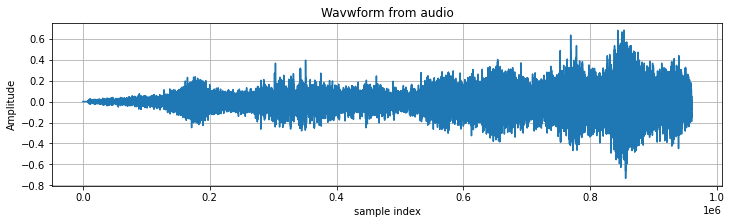

In [57]:
fig=plt.figure(figsize=(12,3))
plt.plot(snd_data[:20 * fs])
plt.xlabel('sample index')
plt.ylabel('Amplitude')
plt.title('Wavwform from audio')
plt.grid()

Calculate RMS sound pressure

$P_{RMS} = \sqrt{\frac{\sum_{dt} s_i^2} {n}}; dt = 0.1 sec;$

$SPL = 20 log_{10} \frac{P_{RMS}} {P_{ref}}$

$mSPL = min(SPL)_{dt}; dt = 1.1 sec$

In [58]:
wint = 0.1                                      # time window 0.1 s
wins = int(wint * fs)                           # time window width in index
n = snd_data.shape[0] // wins                   # number of time windows
p = snd_data[:wins * n].reshape((n, wins))      # change to 2D array
prms = np.sqrt(np.sum(np.square(p), axis=1) / wins)
tend = tstart + (prms.shape[0] -1) * wint       # end time in seconds from midnight
t = np.arange(tstart, tend, wint)

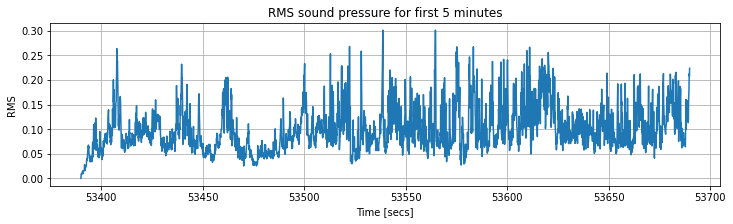

In [59]:
plt.figure(2, figsize=(12,3))
plt.plot(t[:int(300 // wint)], prms[:int(300 // wint)])
plt.xlabel('Time [secs]')
plt.ylabel('RMS')
plt.title('RMS sound pressure for first 5 minutes')
plt.grid()

In [60]:
pref = np.median(prms)
spl = 20 * np.log10(prms / pref)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Let's smooth data with moving median.

In [61]:
win2t = 1.1                     # moving window of 1.1 seconds
win2s = int(win2t // wint)
m = (win2s - 1) // 2
#mspl = np.array([np.median(spl[i-m:i+m]) for i in range(m, n-m-1)])
mspl = np.zeros(n)
for i in range(m, n - m - 1):
    mspl[i] = np.median(spl[i - m: i + m])

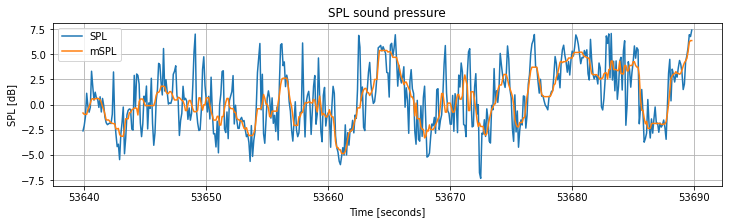

In [62]:
l1 = int(250 // wint)
l2 = int(300 // wint)              # length of plot in seconds
plt.figure(3, figsize=(12,3))
plt.plot(t[l1:l2], spl[l1:l2], label="SPL")
plt.plot(t[l1:l2], mspl[l1:l2], label="mSPL")
plt.xlabel('Time [seconds]')
plt.ylabel('SPL [dB]')
plt.title('SPL sound pressure')
plt.grid()
plt.legend()

33 seconds above critical


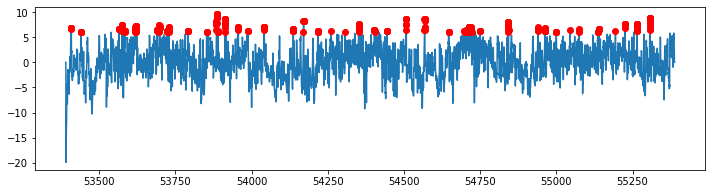

In [63]:
critical = 6
snd = np.c_[t, mspl]
snd_bus = snd[snd[:,1] > critical]
print(f'{snd_bus.shape[0] * wint:.0f} seconds above critical')
plt.figure(4, figsize=(12,3))
plt.plot(t, mspl)
plt.plot(snd_bus[:,0], snd_bus[:,1], 'ro')

In [97]:
start = 0                               # start row index of the first bus
sbus = []
for i in range(1, snd_bus.shape[0]):    # for each row except first
  if snd_bus[i,0] - snd_bus[i-1,0] > wint: # gap -> new bus arrived
    if snd_bus[i-1,0] - snd_bus[start,0] > 0.5:  # pass longer than 0.5 seconds?
      sbus.append((np.average(snd_bus[start:i,0]),
                  np.max(snd_bus[start:i,1]),
                  int(snd_bus[i-1,0] - snd_bus[start, 0] + 0.5)))           # store time, max deflection and duration (sec)
    start = i
# add last
if snd_bus[-1,0] - snd_bus[start,0] > 0.5:
  sbus.append((np.average(snd_bus[start:,0]),
              np.max(snd_bus[start:,1]),
              int(snd_bus[-1,0] - snd_bus[start,0] + 0.5)))
print(f'{len(sbus)} busses found')
print(f'time   max.snd.  duration')
fo = open('sample_data/snd_bus.txt', 'w')
for b in sbus:
  print(f'{datetime.fromtimestamp(b[0]).strftime("%H:%M:%S"):8s} {b[1]:5.1f} {b[2]:5d}')
  print(f'{b[0]:.1f} {b[1]:.1f} {b[2]}', file=fo)
fo.close()

20 busses found
time   max.snd.  duration
14:52:55   7.5     1
14:53:37   7.0     1
14:53:40   7.3     1
14:54:57   7.4     1
14:58:05   9.6     1
14:58:32   8.6     1
14:59:16   7.0     1
15:00:40   7.1     1
15:02:16   6.6     1
15:02:50   8.3     1
15:03:37   6.3     1
15:05:51   7.6     1
15:08:27   8.7     1
15:09:27   8.7     1
15:11:53   7.1     1
15:14:02   8.1     1
15:15:40   7.1     1
15:16:03   6.8     1
15:21:04   7.7     1
15:21:47   8.9     1


## Find bus passes from video record of bus lane

Video record of the bus lane at the middle of the bridge will be processed. We will use OpenCV package.

In [65]:
import cv2
!gdown --id 1wIFIpzRRm_lngAv74D1xMV1wc56_kocI -O sample_data/bridge_vid.mp4
!gdown --id 1P5Bq797ROdvCkIxdXCgHazfI01El2H8_ -O sample_data/empty_bridge.png
!gdown --id 1hiNd2P8q9hfwUYXeC8cYqLZM43PaytAZ -O sample_data/blue_bus.png

Downloading...
From: https://drive.google.com/uc?id=1wIFIpzRRm_lngAv74D1xMV1wc56_kocI
To: /content/sample_data/bridge_vid.mp4
100% 294M/294M [00:01<00:00, 177MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P5Bq797ROdvCkIxdXCgHazfI01El2H8_
To: /content/sample_data/empty_bridge.png
100% 559k/559k [00:00<00:00, 93.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hiNd2P8q9hfwUYXeC8cYqLZM43PaytAZ
To: /content/sample_data/blue_bus.png
100% 213k/213k [00:00<00:00, 69.5MB/s]


Here are two sample images from the video.

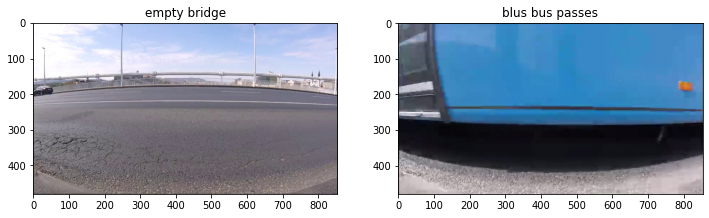

In [66]:
img1 = cv2.imread('sample_data/empty_bridge.png')
img2 = cv2.imread('sample_data/blue_bus.png')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))            # use two subplots horizontaly
ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.title.set_text('empty bridge')
ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.title.set_text('blus bus passes')


What is the difference between the  two images? How can we set up a criteria in a program to separate the two situations?

Fist of all we should use a small part of the image, as the closest lane should be considered  only. Let's cut the image verticaly between 230 and 270 pixels. As a very simple indicator value we can deside by the average of pixels.

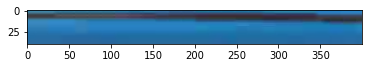

In [67]:
plt.imshow(cv2.cvtColor(img2[230:270,200:600], cv2.COLOR_BGR2RGB))

In [68]:
low = 230
high = 270
left = 200
right = 600
indicator_empty = np.mean(img1[low:high, left:right])
indicator_bus = np.mean(img2[low:high, left:right])
print(f'Emty: {indicator_empty}, Bus: {indicator_bus}')

Emty: 123.200375, Bus: 100.75539583333334


Please actualize the fps and start time.

In [69]:
source = cv2.VideoCapture('sample_data/bridge_vid.mp4')
fps = 30
act = tstart = 14 * 3600 + 49 * 60 + 50   # second from midnight
dt = 1 / fps
video_data = []
while True:
  ret, frame = source.read()                    # read next frame
  if ret:
    val = np.mean(frame[low:high, left:right])  # calculate indicator
    video_data.append((act, val))
    act += dt
  else:
    break
source.release()

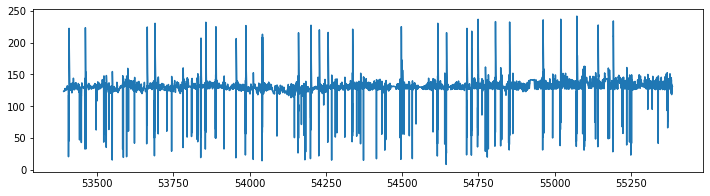

In [70]:
vid_bus = np.array(video_data)
plt.figure(figsize=(12,3))
plt.plot(vid_bus[:,0], vid_bus[:,1])

In [81]:
critical = 60
v_bus = vid_bus[vid_bus[:,1] < critical]
print(f'{v_bus.shape[0] / fps:.0f} seconds below critical')

25 seconds below critical


(746, 2)

In [96]:
start = 0                               # start row index of the first bus
vbus = []
for i in range(1, v_bus.shape[0]):    # for each row except first
  if v_bus[i,0] - v_bus[i-1,0] > 1:   # gap -> new bus arrived
    if v_bus[i-1,0] - v_bus[start,0] > 1: # pass longer than 1 seconds?
      vbus.append((np.average(v_bus[start:i,0]),
                  np.min(v_bus[start:i,1]),
                  int(v_bus[i-1,0] - v_bus[start,0] + 0.5)))           # store time, max deflection and duration (sec)
    start = i
# add last
if v_bus.shape[0] - start > 1:
  vbus.append((np.average(v_bus[start:,0]),
              np.min(v_bus[start:,1]),
              v_bus.shape[0]-start))
print(f'{len(vbus)} busses found')
print(f'time     min.ind. duration')
fo = open('sample_data/vid_bus.txt', 'w')
for b in vbus:
  print(f'{datetime.fromtimestamp(b[0]).strftime("%H:%M:%S"):8s} {b[1]:5.1f} {b[2]:5d}')
  print(f'{b[0]:.1f} {b[1]:.1f} {b[2]}', file=fo)
fo.close()

14 busses found
time     min.ind. duration
14:50:59  32.8     2
14:59:46  23.3     1
15:00:40  14.2     1
15:02:38  26.5     2
15:05:36  44.1     2
15:08:15  16.4     1
15:10:44   8.5     1
15:11:51  23.5     1
15:14:11  31.2     1
15:16:00  31.2     2
15:17:50  36.8     1
15:18:18  36.4     1
15:19:01  36.3     1
15:22:19  41.6     4
